# Text Classification w/ <img src="https://raw.githubusercontent.com/madewithml/images/master/images/pytorch.png" width="25rem"> PyTorch

<div align="left">
<a href="https://github.com/madewithml/e2e-ml-app-pytorch/blob/master/notebook.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/e2e-ml-app-pytorch/blob/master/notebook.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

When building at end-to-end project, I often start with exploring the dataset and doing some basic modeling on a notebook first. The ability to execute code without having to rerun everything start to finish for every iterative change is great way to iterate quickly. 

→ Check out the full repo here: [e2e-ml-app-pytorch](https://github.com/madewithml/e2e-ml-app-pytorch)

In [1]:
import numpy as np
import pandas as pd
import random
import torch

## Set up

In [2]:
seed = 1234
cuda = True

In [3]:
# Set seeds for reproducibility
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# Set device
device = torch.device('cuda' if (
    torch.cuda.is_available() and cuda) else 'cpu')
device

device(type='cuda')

## Load data

In [5]:
data_size = 1.0 # use smaller sizes at the beginning to iterate quickly and catch errors
url = "https://raw.githubusercontent.com/madewithml/lessons/master/data/news.csv"

In [6]:
# Load data
df = pd.read_csv(url)
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


In [7]:
# Reduce dataset
# You should always overfit your models on a small
# dataset first so you can catch errors quickly.
df = df[:int(len(df)*data_size)]
len(df)

120000

In [8]:
# Inputs and outputs
X = df['title'].values
y = df['category'].values
X, y

(array(['Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says',
        'Internet Key Battleground in Wildlife Crime Fight',
        'July Durable Good Orders Rise 1.7 Percent', ...,
        'Musharraf says U.S. must address root of terrorism (Reuters)',
        'Nuclear materials  #39;vanish #39; in Iraq',
        'In Brief: Bowstreet unveils pre-packaged portal offerings'],
       dtype=object),
 array(['World', 'Sci/Tech', 'Business', ..., 'World', 'World', 'Sci/Tech'],
       dtype=object))

## Preprocessing

In [9]:
import re

In [10]:
lower = True

In [11]:
def preprocess_texts(texts, lower=True, filters=r"[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]"):
    preprocessed_texts = []
    for text in texts:
        # lower
        if lower:
            text = text.lower()

        # remove items text in () ex. (Reuters)
        # may want to refine to only remove if at end of text
        text = re.sub(r'\([^)]*\)', '', text)

        # spacing and filters
        text = re.sub(r"([.,!?])", r" \1 ", text)
        text = re.sub(filters, r"", text)
        text = re.sub(' +', ' ', text)  # remove multiple spaces
        text = text.strip()

        preprocessed_texts.append(text)
    return preprocessed_texts

In [12]:
# Preprocesss
original_X = X
X = preprocess_texts(texts=X, lower=lower)
print ("Preprocessed data:\n"
    f"  {original_X[0]} → {X[0]}")

Preprocessed data:
  Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says → sharon accepts plan to reduce gaza army operation haaretz says


## Split data

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
val_size = 0.15
test_size = 0.15
shuffle = True

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split( # creating train and test
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
X_train, X_val, y_train, y_val = train_test_split( # creating train and val
    X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
print ("Data splits:\n"
        f"  X_train: {len(X_train)}, y_train: {len(y_train)}\n"
        f"  X_val: {len(X_val)}, y_val: {len(y_val)}\n"
        f"  X_test: {len(X_test)}, y_test: {len(y_test)}")

Data splits:
  X_train: 86700, y_train: 86700
  X_val: 15300, y_val: 15300
  X_test: 18000, y_test: 18000


## Tokenization

In [16]:
char_level = False

In [17]:
class Tokenizer(object):
    def __init__(self, char_level, pad_token='<PAD>', oov_token='<UNK>',
                 token_to_index={'<PAD>': 0, '<UNK>': 1}):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        self.oov_token = oov_token
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        for text in texts:
            for token in text.split(self.separator):
                if token not in self.token_to_index:
                    index = len(self)
                    self.token_to_index[token] = index
                    self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for token in text.split(self.separator):
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(sequence)
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'char_level': self.char_level,
                'oov_token': self.oov_token,
                'token_to_index': self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [18]:
# Tokenizer
X_tokenizer = Tokenizer(char_level=char_level)
X_tokenizer.fit_on_texts(texts=X_train)
vocab_size = len(X_tokenizer) + 1
print ("X tokenizer:\n"
    f"  {X_tokenizer}")

X tokenizer:
  <Tokenizer(num_tokens=35603)>


In [19]:
# Convert texts to sequences of indices
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = X_tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → fed corporate forecasts to set tone
  (tokenized) → [2, 3, 4, 5, 6, 7]


## Label encoding

In [20]:
class LabelEncoder(object):
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y_train):
        for i, class_ in enumerate(np.unique(y_train)):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def transform(self, y):
        return np.array([self.class_to_index[class_] for class_ in y])

    def decode(self, index):
        return self.index_to_class.get(index, None)

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'class_to_index': self.class_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [21]:
# Label encoder
y_tokenizer = LabelEncoder()
y_tokenizer = y_tokenizer.fit(y_train)
classes = y_tokenizer.classes
print("y tokenizer:\n"
    f"  {y_tokenizer}\n"
    "classes:\n"
    f"  {classes}")

y tokenizer:
  <LabelEncoder(num_classes=4)>
classes:
  ['Business', 'Sci/Tech', 'Sports', 'World']


In [22]:
# Convert labels to tokens
class_ = y_train[0]
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print ("Labels to indices:\n"
    f"  {class_} → {y_train[0]}")

Labels to indices:
  Business → 0


In [23]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print ("class counts:\n"
    f"  {counts}\n"
    "class weights:\n"
    f"  {class_weights}")

class counts:
  [21675 21675 21675 21675]
class weights:
  {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


## Dataset

In [24]:
filter_sizes = [2, 3, 4]
batch_size = 64

In [25]:
def pad_sequences(sequences, max_seq_len=0):
    max_seq_len = max(max_seq_len, max(len(sequence)
                                       for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [26]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        X = np.array(batch)[:, 0]
        y = np.array(batch)[:, 1]

        # Pad inputs
        X = pad_sequences(sequences=X, max_seq_len=self.max_filter_size)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

In [27]:
# Create datasets
train_dataset = TextDataset(
    X=X_train, y=y_train, max_filter_size=max(filter_sizes))
val_dataset = TextDataset(
    X=X_val, y=y_val, max_filter_size=max(filter_sizes))
test_dataset = TextDataset(
    X=X_test, y=y_test, max_filter_size=max(filter_sizes))
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  {train_dataset[0]}")

Data splits:
  Train dataset:<Dataset(N=86700)>
  Val dataset: <Dataset(N=15300)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  ([2, 3, 4, 5, 6, 7], 0)


In [28]:
# Create dataloaders
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [64, 13]
  y: [64]


## Model

In [29]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [30]:
embedding_dim = 100
num_filters = 50
hidden_dim = 128
dropout_p = 0.1
freeze_embeddings = False

In [31]:
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, filter_sizes,
                 hidden_dim, dropout_p, num_classes, pretrained_embeddings=None,
                 freeze_embeddings=False, padding_idx=0):
        super(TextCNN, self).__init__()

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(
                pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)

        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

        # Conv weights
        self.filter_sizes = filter_sizes
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, channel_first=False):

        # Embed
        x_in = self.embeddings(x_in)
        if not channel_first:
            x_in = x_in.transpose(1, 2)  # (N, channels, sequence length)

        z = []
        conv_outputs = []  # for interpretability
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):

            # `SAME` padding
            padding_left = int(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            conv_outputs.append(_z)

            # Pool
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        # Concat outputs
        z = torch.cat(z, 1)

        # FC
        z = self.fc1(z)
        z = self.dropout(z)
        logits = self.fc2(z)

        return conv_outputs, logits

In [32]:
# Initialize model
model = TextCNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=len(y_tokenizer.classes),
    freeze_embeddings=freeze_embeddings)
model = model.to(device)
print ("Model:\n"
    f"  {model.named_parameters}")

Model:
  <bound method Module.named_parameters of TextCNN(
  (embeddings): Embedding(35604, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)>


## Compile

In [33]:
learning_rate = 1e-4

In [34]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3)

## Training

In [35]:
num_epochs = 20
patience = 3

In [36]:
def train_step(model, optimizer, dataloader, device):
    """Train step."""
    # Set model to train mode
    model.train()
    train_loss, correct = 0., 0

    # Iterate over train batches
    num_batches = len(dataloader)
    for i, (X, y) in enumerate(dataloader):

        # Step
        X, y = X.to(device), y.to(device)  # Set device
        optimizer.zero_grad()  # Reset gradients
        _, logits = model(X)  # Forward pass
        loss = F.cross_entropy(logits, y)  # Define loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Metrics
        y_pred = logits.max(dim=1)[1]
        correct += torch.eq(y_pred, y).sum().item()
        train_loss += (loss.detach().item() - train_loss) / (i + 1)

    train_acc = 100. * correct / len(dataloader.dataset)
    return train_loss, train_acc

In [37]:
def test_step(model, dataloader, device):
    """Validation or test step."""
    # Set model to eval mode
    model.eval()
    loss, correct = 0., 0
    y_preds, y_targets = [], []

    # Iterate over val batches
    num_batches = len(dataloader)
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):

            # Step
            X, y = X.to(device), y.to(device)  # Set device
            _, logits = model(X)  # Forward pass

            # Metrics
            loss += F.cross_entropy(logits, y, reduction='sum').item()
            y_pred = logits.max(dim=1)[1]
            correct += torch.eq(y_pred, y).sum().item()

            # Store outputs
            y_preds.extend(y_pred.cpu().numpy())
            y_targets.extend(y.cpu().numpy())

    loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    return loss, accuracy, y_preds, y_targets

In [38]:
def train(model, optimizer, scheduler, num_epochs, patience,
          train_dataloader, val_dataloader, test_dataloader, device):
    best_val_loss = np.inf
    print ("Training:")
    for epoch in range(num_epochs):
        # Steps
        train_loss, train_acc = train_step(model, optimizer, train_dataloader, device)
        val_loss, val_acc, _, _ = test_step(model, val_dataloader, device)

        # Metrics
        print (
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.2f}, train_acc: {train_acc:.1f}, "
            f"val_loss: {val_loss:.2f}, val_acc: {val_acc:.1f}")

        # Adjust learning rate
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            _patience = patience  # reset _patience
        else:
            _patience -= 1
        if not _patience:  # 0
            print ("Stopping early!")
            break

    return best_val_loss

In [39]:
# Train
best_val_loss = train(
    model=model, optimizer=optimizer, scheduler=scheduler,
    num_epochs=num_epochs, patience=patience,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    device=device)

Training:
Epoch: 1 | train_loss: 1.22, train_acc: 46.0, val_loss: 1.04, val_acc: 58.1
Epoch: 2 | train_loss: 0.91, train_acc: 64.3, val_loss: 0.86, val_acc: 66.6
Epoch: 3 | train_loss: 0.74, train_acc: 72.2, val_loss: 0.78, val_acc: 70.1
Epoch: 4 | train_loss: 0.63, train_acc: 76.7, val_loss: 0.75, val_acc: 71.8
Epoch: 5 | train_loss: 0.56, train_acc: 79.7, val_loss: 0.74, val_acc: 72.9
Epoch: 6 | train_loss: 0.50, train_acc: 82.1, val_loss: 0.74, val_acc: 73.5
Epoch: 7 | train_loss: 0.45, train_acc: 84.2, val_loss: 0.74, val_acc: 74.1
Epoch: 8 | train_loss: 0.41, train_acc: 85.9, val_loss: 0.76, val_acc: 74.3
Epoch: 9 | train_loss: 0.37, train_acc: 87.4, val_loss: 0.77, val_acc: 74.4
Stopping early!


## Evaluation


In [40]:
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [41]:
# Evaluation
test_loss, test_acc, y_pred, y_target = test_step(
    model=model, dataloader=test_dataloader, device=device)
print ("Test performance:\n"
    f"  test_loss: {test_loss:.2f}, test_acc: {test_acc:.1f}")

Test performance:
  test_loss: 0.78, test_acc: 74.3


In [42]:
# Performance
performance = {'overall': {}, 'class': {}}
metrics = precision_recall_fscore_support(y_test, y_pred)

# Overall performance
performance['overall']['precision'] = np.mean(metrics[0])
performance['overall']['recall'] = np.mean(metrics[1])
performance['overall']['f1'] = np.mean(metrics[2])
performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

# Per-class performance
for i in range(len(classes)):
    performance['class'][classes[i]] = {
        "precision": metrics[0][i],
        "recall": metrics[1][i],
        "f1": metrics[2][i],
        "num_samples": np.float64(metrics[3][i])
    }

print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.7431059739757412,
    "recall": 0.7427222222222223,
    "f1": 0.7421762653808817,
    "num_samples": 18000.0
  },
  "class": {
    "Business": {
      "precision": 0.7377521613832853,
      "recall": 0.6826666666666666,
      "f1": 0.7091412742382271,
      "num_samples": 4500.0
    },
    "Sci/Tech": {
      "precision": 0.712818317997004,
      "recall": 0.7402222222222222,
      "f1": 0.7262618554453286,
      "num_samples": 4500.0
    },
    "Sports": {
      "precision": 0.7498459642637092,
      "recall": 0.8113333333333334,
      "f1": 0.7793788024335574,
      "num_samples": 4500.0
    },
    "World": {
      "precision": 0.772007452258966,
      "recall": 0.7366666666666667,
      "f1": 0.7539231294064135,
      "num_samples": 4500.0
    }
  }
}


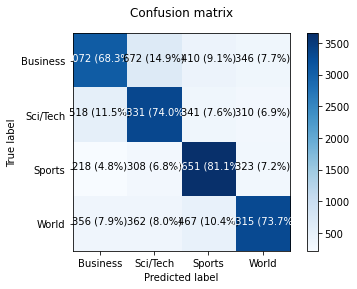

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#  Figure
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

# Axis
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()

# Values
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

## Prediction

In [44]:
from collections import Counter
from collections import defaultdict

In [45]:
text = input("Enter text to classify: ")

Enter text to classify: The Canadian government officials proposed the new federal law.


In [53]:
# Preprocess
preprocessed_texts = preprocess_texts([text], lower=lower)
print (preprocessed_texts[0])

the canadian government officials proposed the new federal law


In [54]:
# Create dataset
X = np.array(X_tokenizer.texts_to_sequences(preprocessed_texts))
y_filler = np.array([0]*len(X))
dataset = TextDataset(
    X=X, y=y_filler, max_filter_size=max(filter_sizes))
dataloader = dataset.create_dataloader(
    batch_size=batch_size)

In [55]:
def predict_step(model, dataloader, filter_sizes, device):
    """Predict step."""
    model.eval()
    conv_outputs = defaultdict(list)
    y_probs = []
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):

            # Set device
            X, y = X.to(device), y.to(device)

            # Forward pass
            conv_outputs_, logits = model(X)
            y_prob = F.softmax(logits, dim=1)

            # Save probabilities
            y_probs.extend(y_prob.cpu().numpy())
            for i, filter_size in enumerate(filter_sizes):
                conv_outputs[filter_size].extend(
                    conv_outputs_[i].cpu().numpy())

    return y_probs, conv_outputs

In [56]:
# Predict
y_prob, conv_outputs = predict_step(
    model=model.cpu(), dataloader=dataloader,
    filter_sizes=filter_sizes, device='cpu')

In [57]:
# Probability distribution
prob_dist = {}
for i, class_ in enumerate(classes):
    prob_dist[class_] = np.float64(y_prob[0][i])
prob_dist = {k: v for k, v in sorted(
    prob_dist.items(), key=lambda item: item[1], reverse=True)}

In [58]:
# Process conv outputs for each unique filter size
n_grams = {}
conv_outputs = {k: v[0] for k, v in conv_outputs.items()}
tokens = preprocessed_texts[0].split(' ')
for i, filter_size in enumerate(filter_sizes):

    # Identify most important n-gram for each filter's output
    popular_indices = Counter(
        np.argmax(conv_outputs[filter_size], axis=1))

    # Get corresponding text
    start = popular_indices.most_common(2)[-1][0]
    end = min(len(tokens), start+filter_size)
    n_gram = " ".join([token for token in tokens[start:end]])
    n_grams[filter_size] = {
        'n_gram': n_gram,
        'start': np.float64(start),
        'end': np.float64(end)
        }

In [59]:
print ('raw_input:', text)
print ('preprocessed_input:', preprocessed_texts[0])
print ('probabilities:\n', json.dumps(prob_dist, indent=2))
print ('top_n_grams:\n', json.dumps(n_grams, indent=2))

raw_input: The Canadian government officials proposed the new federal law.
preprocessed_input: the canadian government officials proposed the new federal law
probabilities:
 {
  "Sci/Tech": 0.6987228989601135,
  "Business": 0.17412935197353363,
  "World": 0.11796557903289795,
  "Sports": 0.009182196110486984
}
top_n_grams:
 {
  "2": {
    "n_gram": "officials proposed",
    "start": 3.0,
    "end": 5.0
  },
  "3": {
    "n_gram": "proposed the new",
    "start": 4.0,
    "end": 7.0
  },
  "4": {
    "n_gram": "federal law",
    "start": 7.0,
    "end": 9.0
  }
}


---
Learn, explore and build at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.youtube.com/channel/UCaVCnFQXS7PYMoYZu3KdC0Q?sub_confirmation=1"><img src="https://img.shields.io/badge/style--5eba00.svg?label=YouTube&logo=youtube&style=social"></a>&nbsp;<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             